Training Logistic Regression...
Accuracy Logistic Regression: 0.86


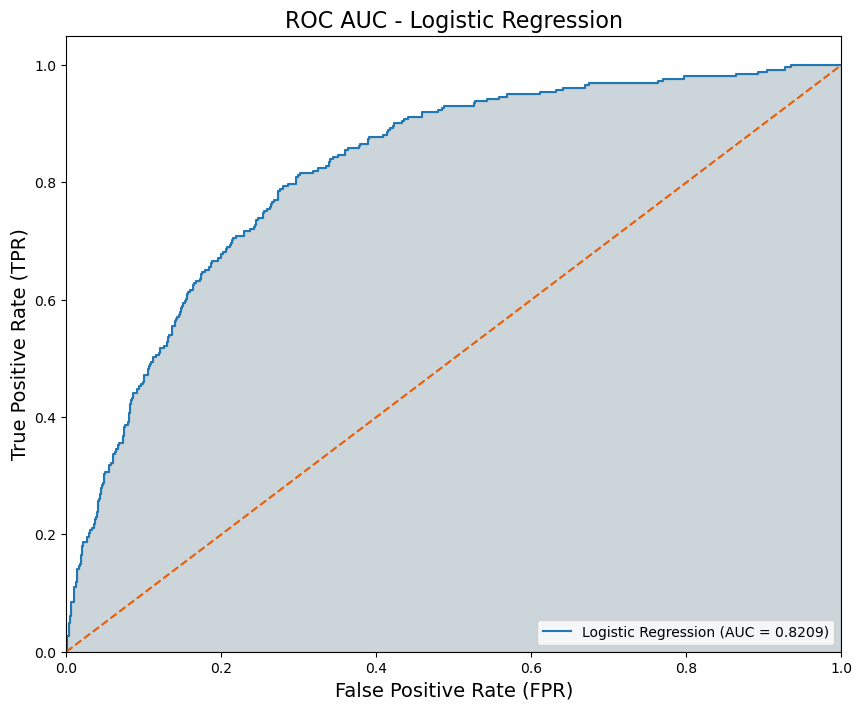

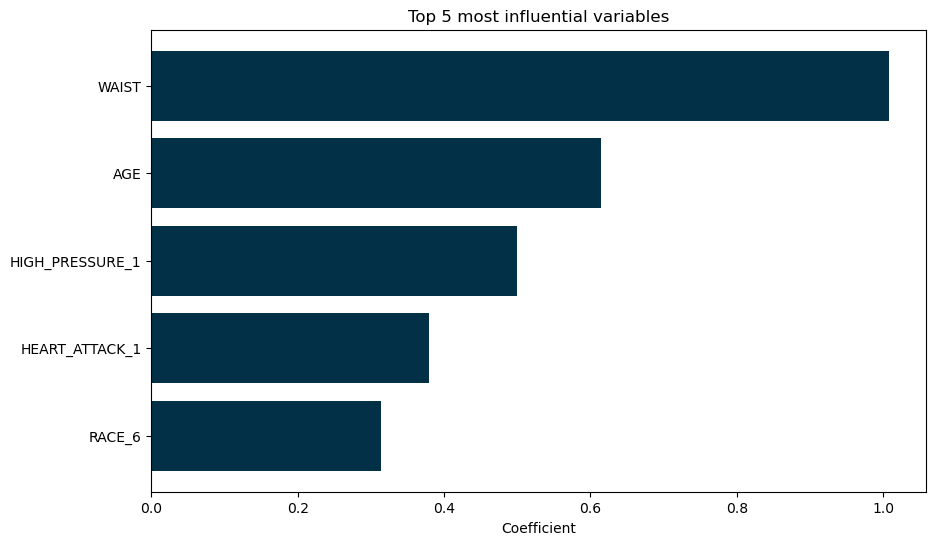

Training Decision Tree...
Accuracy Decision Tree: 0.79


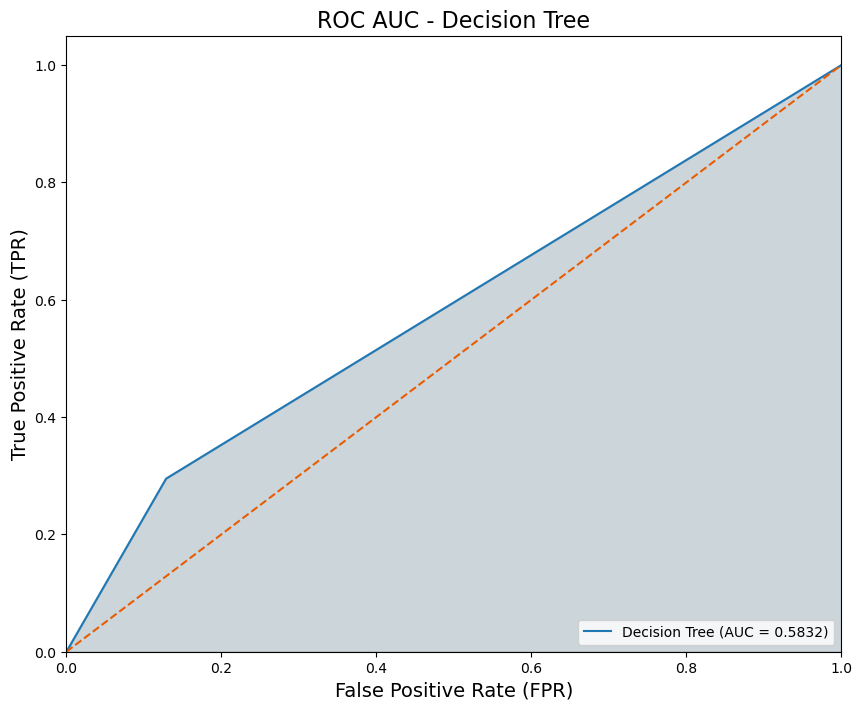

Training Random Forest...
Accuracy Random Forest: 0.86


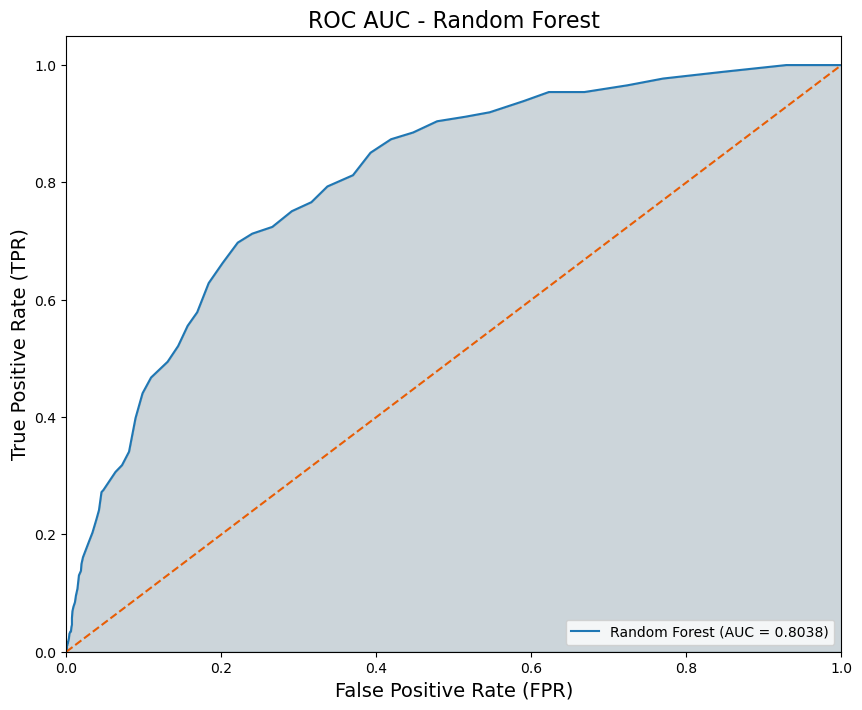

Training SVM...
Accuracy SVM: 0.86


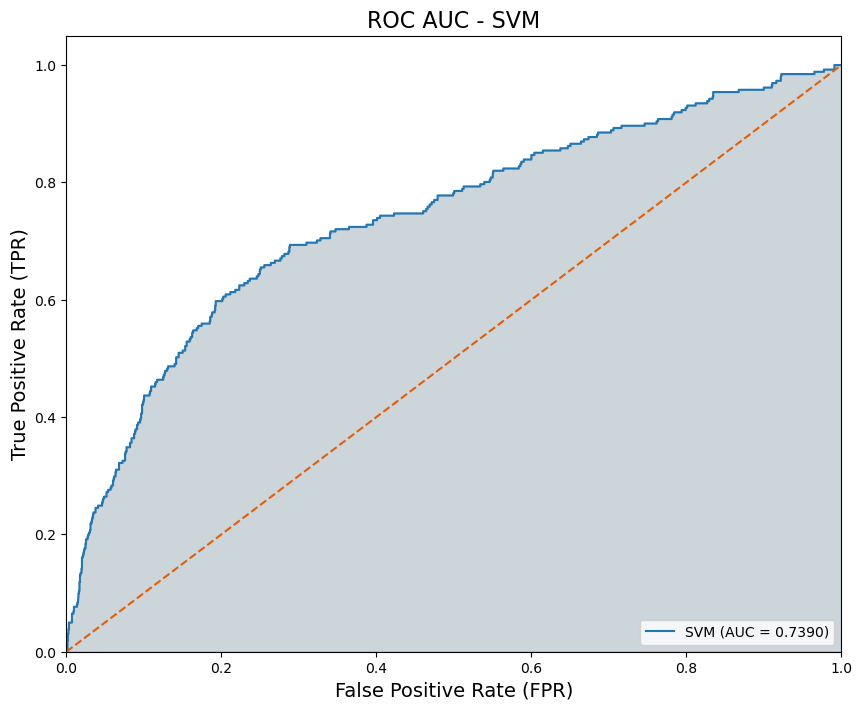

Training XGBoost...
Accuracy XGBoost: 0.86


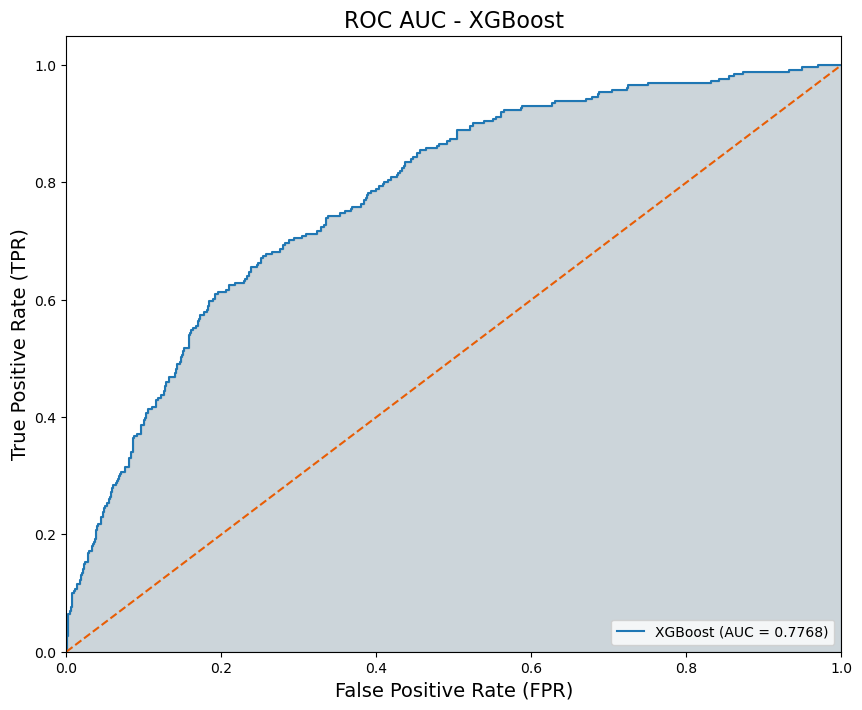

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV


# Função para codificar variáveis e padronizar dados
def preprocess_data(df, alvo):
    # Dicionário para mapear a variável alvo para suas respectivas variáveis categóricas
    categorical_vars_dict = {
        'DIABETES': [
            'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
            'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
            'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
            'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
            'CORONARY_DISEASE', 'HEART_ATTACK', 'STROKE', 'THYROID_PROBLEMA', 
            'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
            'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
        ],
        'HEART_ATTACK': [
            'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
            'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
            'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
            'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
            'CORONARY_DISEASE', 'DIABETES', 'STROKE', 'THYROID_PROBLEMA', 
            'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
            'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
        ],
        'STROKE': [
            'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
            'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
            'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
            'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
            'CORONARY_DISEASE', 'DIABETES', 'HEART_ATTACK', 'THYROID_PROBLEMA', 
            'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
            'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
        ]
    }

    # Selecionar as variáveis categóricas correspondentes ao alvo
    categorical_vars = categorical_vars_dict.get(alvo, [])

    # Separar o alvo e as features
    y = df[alvo]
    X = df.drop(columns=[alvo])
    
    # Codificar variáveis categóricas
    X_encoded = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
    
    # Padronizar variáveis numéricas
    numerical_vars = X_encoded.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X_encoded[numerical_vars] = scaler.fit_transform(X_encoded[numerical_vars])
    
    return X_encoded, y

def plot_roc_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    else:
        raise ValueError(f"O modelo {model_name} não suporta previsão de probabilidade.")
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='#e85d04', linestyle='--')
    plt.fill_between(fpr, tpr, alpha=0.2, color='#023047')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'ROC AUC - {model_name}', fontsize=16)
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.show()

def plot_top_features(coef_df, top_n=5):
    # Ordenar os coeficientes em ordem decrescente
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    # Selecionar as top_n variáveis
    top_features = coef_df.head(top_n)
    
    # Plotar
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Coefficient'], color='#023047')
    plt.xlabel('Coefficient')
    plt.title(f'Top {top_n} most influential variables')
    plt.gca().invert_yaxis()  # Inverter a ordem para mostrar o maior coeficiente no topo
    plt.grid(False)
    plt.show()

df = pd.read_excel('dados_agregados_limpos.xlsx')

# Processar dados
X_encoded, y = preprocess_data(df, 'DIABETES')

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Modelos a serem testados
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42), 
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

# Treinar, prever e avaliar modelos
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy {model_name}: {accuracy:.2f}")
    
    # Plotar curva ROC
    plot_roc_curve(model, X_test, y_test, model_name)
    
    # Se o modelo tiver coeficientes, plote os top 5
    if hasattr(model, 'coef_'):
        coefficients = model.coef_[0]
        features = X_train.columns
        
        # Criar DataFrame com variáveis e coeficientes
        coef_df = pd.DataFrame({
            'Feature': features,
            'Coefficient': coefficients
        })
        
        # Plotar as 5 variáveis com maior coeficiente em ordem decrescente
        plot_top_features(coef_df, top_n=5)



In [ ]:
def run():
    st.title("Página 3 - Script 3")
    st.write("Conteúdo do Script 3")

    def preprocess_data(df, alvo):
        categorical_vars_dict = {
            'DIABETES': [
                'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
                'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
                'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
                'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
                'CORONARY_DISEASE', 'HEART_ATTACK', 'STROKE', 'THYROID_PROBLEMA', 
                'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
                'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
            ],
            'HEART_ATTACK': [
                'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
                'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
                'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
                'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
                'CORONARY_DISEASE', 'DIABETES', 'STROKE', 'THYROID_PROBLEMA', 
                'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
                'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
            ],
            'STROKE': [
                'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
                'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
                'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
                'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
                'CORONARY_DISEASE', 'DIABETES', 'HEART_ATTACK', 'THYROID_PROBLEMA', 
                'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
                'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
            ]
        }

        categorical_vars = categorical_vars_dict.get(alvo, [])

        y = df[alvo]
        X = df.drop(columns=[alvo])
        
        X_encoded = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
        
        numerical_vars = X_encoded.select_dtypes(include=['float64', 'int64']).columns
        scaler = StandardScaler()
        X_encoded[numerical_vars] = scaler.fit_transform(X_encoded[numerical_vars])
        
        return X_encoded, y

    def plot_roc_curve(model, X_test, y_test, model_name, num_classes=None):
        fig, ax = plt.subplots(figsize=(8, 6))
        if num_classes and num_classes > 2:
            from sklearn.preprocessing import label_binarize
            
            y_test_bin = label_binarize(y_test, classes=model.classes_)
            y_prob = model.predict_proba(X_test)
            
            fpr = {}
            tpr = {}
            roc_auc = {}
            for i in range(y_test_bin.shape[1]):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            for i in range(y_test_bin.shape[1]):
                ax.plot(fpr[i], tpr[i], label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.4f})')
            ax.plot([0, 1], [0, 1], color='#e85d04', linestyle='--')
            ax.fill_between(fpr[i], tpr[i], alpha=0.2, color='#023047')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
            ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
            ax.set_title(f'ROC AUC - {model_name} (Multiclass)', fontsize=14)
            ax.legend(loc='lower right')
            ax.grid(False)
        else:
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_prob = model.decision_function(X_test)
                y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
            else:
                raise ValueError(f"O modelo {model_name} não suporta previsão de probabilidade.")
            
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
            ax.plot([0, 1], [0, 1], color='#e85d04', linestyle='--')
            ax.fill_between(fpr, tpr, alpha=0.2, color='#023047')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
            ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
            ax.set_title(f'ROC AUC - {model_name}', fontsize=14)
            ax.legend(loc='lower right')
            ax.grid(False)

        # Salvar imagem em um buffer
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        img_base64 = base64.b64encode(buffer.getvalue()).decode()
        st.markdown(f'<div style="text-align: center;"><img src="data:image/png;base64,{img_base64}" style="max-width: 100%; height: auto;" /></div>', unsafe_allow_html=True)

        # Texto específico para cada combinação de modelo e doença
        texts = {
            ('DIABETES', 'Logistic Regression'): "Texto específico para Diabetes e Regressão Logística.",
            ('DIABETES', 'Random Forest'): "Texto específico para Diabetes e Random Forest.",
            ('DIABETES', 'Decision Tree'): "Texto específico para Diabetes e Decision Tree.",
            ('DIABETES', 'SVM'): "Texto específico para Diabetes e SVM.",
            ('DIABETES', 'XGBoost'): "Texto específico para Diabetes e xgboost.",


            ('HEART_ATTACK', 'Logistic Regression'): "Texto específico para Ataque Cardíaco e Regressão Logística.",
            ('HEART_ATTACK', 'Random Forest'): "Texto específico para Ataque Cardíaco e Random Forest.",
            ('HEART_ATTACK', 'Decision Tree'): "Texto específico para Diabetes e Decision Tree.",
            ('HEART_ATTACK', 'SVM'): "Texto específico para Diabetes e SVM.",
            ('HEART_ATTACK', 'XGBoost'): "Texto específico para Diabetes e xgboost.",

            ('STROKE', 'Logistic Regression'): "Texto específico para Acidente Vascular Cerebral e Regressão Logística.",
            ('STROKE', 'Random Forest'): "Texto específico para Acidente Vascular Cerebral e Random Forest.",
            ('STROKE', 'Decision Tree'): "Texto específico para Diabetes e Decision Tree.",
            ('STROKE', 'SVM'): "Texto específico para Diabetes e SVM.",
            ('STROKE', 'XGBoost'): "Texto específico para Diabetes e xgboost."
        }
        
        key = (alvo, model_name)
        st.write(texts.get(key, "Texto padrão para essa combinação não disponível."))

        plt.close(fig)

    def plot_top_features(coef_df, top_n=5):
        color_palette = ['#023047', '#e85d04', '#0077b6', '#0096c7', '#ff9c33']
        top_features = coef_df.sort_values(by='Coefficient', ascending=False).head(top_n)
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=color_palette, ax=ax)
        ax.set_title('Top 5 Variáveis - Regressão Logística', fontsize=14)
        ax.set_xlabel('Coeficiente', fontsize=12)
        ax.set_ylabel('Variável', fontsize=12)
        ax.grid(False)
        plt.yticks
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        
        # Salvar imagem em um buffer
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        img_base64 = base64.b64encode(buffer.getvalue()).decode()
        st.markdown(f'<div style="text-align: center;"><img src="data:image/png;base64,{img_base64}" style="max-width: 100%; height: auto;" /></div>', unsafe_allow_html=True)

        plt.close(fig)

    # Carregar dados e realizar o pré-processamento
    df = pd.read_excel(r"C:\Users\leosz\Desktop\Streamlit_Nhanes\dados_demograficos_streamlit.xlsx")
    
    # Selecione a doença e o modelo a partir das seleções do usuário
    model_name = st.selectbox("Selecione o Modelo", ["Logistic Regression", "Random Forest", "Decision Tree", "SVM", "XGBoost"])
    alvo = st.selectbox("Selecione a Doença", ["DIABETES", "HEART_ATTACK", "STROKE"])

    # Pré-processar dados para a doença selecionada
    X, y = preprocess_data(df, alvo)

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Treinar o modelo selecionado
    if model_name == "Logistic Regression":
        model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
    elif model_name == "Random Forest":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == "SVM":
        model = SVC(probability=True, kernel='linear', random_state=42)
    elif model_name == "XGBoost":
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    else:
        st.error("Modelo não suportado")
        return

    model.fit(X_train, y_train)
    
    # Plotar a curva ROC
    plot_roc_curve(model, X_test, y_test, model_name, num_classes=len(set(y)))
    
    # Plotar gráfico das principais características se for Regressão Logística
    if model_name == "Logistic Regression":
        coef_df = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_[0]
        })
        plot_top_features(coef_df)

if __name__ == "__main__":
    run()


In [ ]:

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import base64
from io import BytesIO

def run():
    st.title("Página 3 - Script 3")
    st.write("Conteúdo do Script 3")

    def preprocess_data(df, alvo):
        categorical_vars_dict = {
            'DIABETES': [
                'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
                'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
                'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
                'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
                'CORONARY_DISEASE', 'HEART_ATTACK', 'STROKE', 'THYROID_PROBLEMA', 
                'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
                'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
            ],
            'HEART_ATTACK': [
                'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
                'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
                'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
                'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
                'CORONARY_DISEASE', 'DIABETES', 'STROKE', 'THYROID_PROBLEMA', 
                'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
                'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
            ],
            'STROKE': [
                'ALCOHOL_FREQUENCY', 'VIGOROUS_ACTIVITY', 'MODERATE_ACTIVITY', 'SMOKE', 
                'KIDNEY_DISEASE', 'DIALYSES', 'GENDER', 'RACE', 'EDUCATION', 
                'MARITAL_STATUS', 'HIGH_PRESSURE', 'HIGH_CHOLESTEROL', 
                'ASTHMA', 'BLOOD_TRANSFUSION', 'ARTHRITIS', 'CONGESTIVE_HEART_FAILURE', 
                'CORONARY_DISEASE', 'DIABETES', 'HEART_ATTACK', 'THYROID_PROBLEMA', 
                'COPD', 'LIVER_DISEASE', 'ABDOMINAL_PAIN', 'GALLSTONES', 'CANCER', 
                'HEALTH_INSURANCE', 'SNORE', 'SNORT', 'TROUBLE_SLEEPING', 'OVERLY_SLEEPY'
            ]
        }

        categorical_vars = categorical_vars_dict.get(alvo, [])

        y = df[alvo]
        X = df.drop(columns=[alvo])
        
        X_encoded = pd.get_dummies(X, columns=categorical_vars, drop_first=True)
        
        numerical_vars = X_encoded.select_dtypes(include=['float64', 'int64']).columns
        scaler = StandardScaler()
        X_encoded[numerical_vars] = scaler.fit_transform(X_encoded[numerical_vars])
        
        return X_encoded, y

    def plot_roc_curve(model, X_test, y_test, model_name, num_classes=None):
        fig, ax = plt.subplots(figsize=(8, 6))
        if num_classes and num_classes > 2:
            from sklearn.preprocessing import label_binarize
            
            y_test_bin = label_binarize(y_test, classes=model.classes_)
            y_prob = model.predict_proba(X_test)
            
            fpr = {}
            tpr = {}
            roc_auc = {}
            for i in range(y_test_bin.shape[1]):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            for i in range(y_test_bin.shape[1]):
                ax.plot(fpr[i], tpr[i], label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.4f})')
            ax.plot([0, 1], [0, 1], color='#e85d04', linestyle='--')
            ax.fill_between(fpr[i], tpr[i], alpha=0.2, color='#023047')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
            ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
            ax.set_title(f'ROC AUC - {model_name} (Multiclass)', fontsize=14)
            ax.legend(loc='lower right')
            ax.grid(False)
        else:
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_prob = model.decision_function(X_test)
                y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
            else:
                raise ValueError(f"O modelo {model_name} não suporta previsão de probabilidade.")
            
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
            ax.plot([0, 1], [0, 1], color='#e85d04', linestyle='--')
            ax.fill_between(fpr, tpr, alpha=0.2, color='#023047')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
            ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
            ax.set_title(f'ROC AUC - {model_name}', fontsize=14)
            ax.legend(loc='lower right')
            ax.grid(False)

        # Salvar imagem em um buffer
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        img_base64 = base64.b64encode(buffer.getvalue()).decode()
        st.markdown(f'<div style="text-align: center;"><img src="data:image/png;base64,{img_base64}" style="max-width: 100%; height: auto;" /></div>', unsafe_allow_html=True)

        # Texto específico para cada combinação de modelo e doença
        texts = {
            ('DIABETES', 'Logistic Regression'): "Texto específico para Diabetes e Regressão Logística.",
            ('DIABETES', 'Random Forest'): "Texto específico para Diabetes e Random Forest.",
            ('DIABETES', 'Decision Tree'): "Texto específico para Diabetes e Decision Tree.",
            ('DIABETES', 'SVM'): "Texto específico para Diabetes e SVM.",
            ('DIABETES', 'XGBoost'): "Texto específico para Diabetes e xgboost.",


            ('HEART_ATTACK', 'Logistic Regression'): "Texto específico para Ataque Cardíaco e Regressão Logística.",
            ('HEART_ATTACK', 'Random Forest'): "Texto específico para Ataque Cardíaco e Random Forest.",
            ('HEART_ATTACK', 'Decision Tree'): "Texto específico para Diabetes e Decision Tree.",
            ('HEART_ATTACK', 'SVM'): "Texto específico para Diabetes e SVM.",
            ('HEART_ATTACK', 'XGBoost'): "Texto específico para Diabetes e xgboost.",

            ('STROKE', 'Logistic Regression'): "Texto específico para Acidente Vascular Cerebral e Regressão Logística.",
            ('STROKE', 'Random Forest'): "Texto específico para Acidente Vascular Cerebral e Random Forest.",
            ('STROKE', 'Decision Tree'): "Texto específico para Diabetes e Decision Tree.",
            ('STROKE', 'SVM'): "Texto específico para Diabetes e SVM.",
            ('STROKE', 'XGBoost'): "Texto específico para Diabetes e xgboost."
        }
        
        key = (alvo, model_name)
        st.write(texts.get(key, "Texto padrão para essa combinação não disponível."))

        plt.close(fig)

    def plot_top_features(coef_df, top_n=5):
        color_palette = ['#023047', '#e85d04', '#0077b6', '#0096c7', '#ff9c33']
        top_features = coef_df.sort_values(by='Coefficient', ascending=False).head(top_n)
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=color_palette, ax=ax)
        ax.set_title('Top 5 Variáveis - Regressão Logística', fontsize=14)
        ax.set_xlabel('Coeficiente', fontsize=12)
        ax.grid(False)
        plt.yticks(rotation = 45)
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        
        # Salvar imagem em um buffer
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        img_base64 = base64.b64encode(buffer.getvalue()).decode()
        st.markdown(f'<div style="text-align: center;"><img src="data:image/png;base64,{img_base64}" style="max-width: 100%; height: auto;" /></div>', unsafe_allow_html=True)

        plt.close(fig)

    # Carregar dados e realizar o pré-processamento
    df = pd.read_excel(r"C:\Users\leosz\Desktop\Streamlit_Nhanes\dados_demograficos_streamlit.xlsx")
    
    # Selecione a doença e o modelo a partir das seleções do usuário
    model_name = st.selectbox("Selecione o Modelo", ["Logistic Regression", "Random Forest", "Decision Tree", "SVM", "XGBoost"])
    alvo = st.selectbox("Selecione a Doença", ["DIABETES", "HEART_ATTACK", "STROKE"])

    # Pré-processar dados para a doença selecionada
    X, y = preprocess_data(df, alvo)

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Treinar o modelo selecionado
    if model_name == "Logistic Regression":
        model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
    elif model_name == "Random Forest":
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "Decision Tree":
        model = DecisionTreeClassifier(random_state=42)
    elif model_name == "SVM":
        model = SVC(probability=True, kernel='linear', random_state=42)
    elif model_name == "XGBoost":
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    else:
        st.error("Modelo não suportado")
        return

    model.fit(X_train, y_train)
    
    # Plotar a curva ROC
    plot_roc_curve(model, X_test, y_test, model_name, num_classes=len(set(y)))
    
    # Plotar gráfico das principais características se for Regressão Logística
    if model_name == "Logistic Regression":
        coef_df = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_[0]
        })
        plot_top_features(coef_df)

if __name__ == "__main__":
    run()